<a href="https://colab.research.google.com/github/Barryjuait/Barryjuait/blob/master/Dysk_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from __future__ import print_function
import os
import sys
import pandas as pd
import numpy as np
import random
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Activation, Dense, Input, Dropout, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, Flatten, AveragePooling1D, LeakyReLU, BatchNormalization, UpSampling1D, Reshape
from keras.optimizers import SGD
from keras.models import Model, Sequential, load_model
from keras.callbacks import ModelCheckpoint
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from scipy.interpolate import interp1d
from sklearn.model_selection import KFold, StratifiedKFold
from keras.utils import to_categorical

import scikitplot
from scikitplot.metrics import plot_confusion_matrix, plot_roc, plot_cumulative_gain, plot_precision_recall, plot_lift_curve
from sklearn.metrics import confusion_matrix, roc_curve, auc


# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [4]:
#set current working directory
path = '/content/drive/MyDrive/Colab Notebooks/'
os.chdir(path)

In [5]:
#Read the dataset into a pandas.DataFrame
df = pd.read_csv(path + 'CollectedSpectra.csv')

In [6]:
#make a copy:
Data = df.copy();

In [7]:
#remove nans:
df.dropna(subset=['State'], axis=0, inplace=True);
df.reset_index(drop=True, inplace=True);

In [8]:
#leave only right hemisphere:
df.drop(df[np.logical_and(df['State'] == 4, df.Hemi == 1)].index, inplace = True);

#update:
y = df.State.astype('category');
df.drop(['Acc', 'Hemi', 'State'], axis = 1, inplace = True);
df.reset_index(drop = True, inplace = True);


In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
x0,4635.0,0.475097,0.403389,-0.889902,0.212801,0.480442,0.746572,1.932049
x0_5,4635.0,0.507264,0.370459,-0.717240,0.267635,0.515533,0.748196,1.881730
x1,4635.0,0.550767,0.333648,-0.690098,0.329821,0.563507,0.765773,1.726825
x1_5,4635.0,0.604739,0.320926,-0.504026,0.403742,0.610680,0.808423,2.061490
x2,4635.0,0.626597,0.339259,-0.513940,0.418046,0.634709,0.837840,2.008428
...,...,...,...,...,...,...,...,...
x150,4635.0,0.453519,0.910372,-1.823724,0.022280,0.373724,0.712419,11.347413
AIMS,4635.0,4.500809,6.589275,0.000000,0.000000,0.000000,7.500000,30.000000
Session,4635.0,180.223732,50.964993,81.000000,140.000000,178.000000,228.000000,250.000000
Drug,4635.0,2.423948,0.967975,1.000000,2.000000,2.000000,3.000000,4.000000


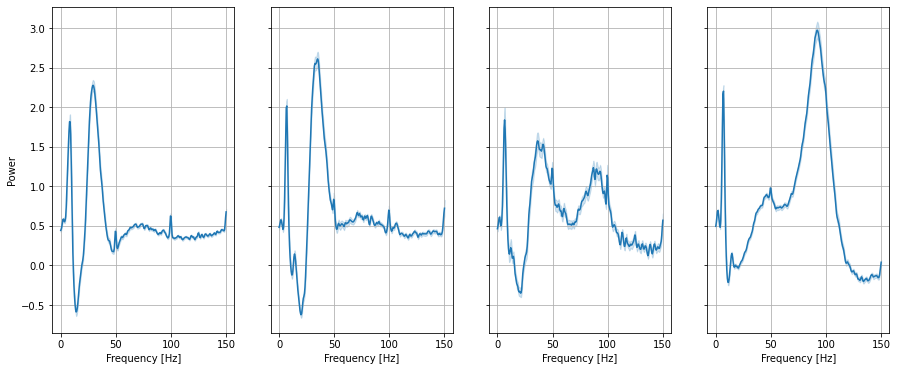

In [10]:
fig, ax = plt.subplots(1,4,figsize = (15,6), sharey = True);

faxis = np.arange(0, 150.5, 0.5);
for ix in range(4):
  a = df.loc[y == ix,'x0':'x150'];
  a.columns = faxis;
  a = a.reset_index();

  melted = a.melt(id_vars='index', var_name='faxis', value_name='power_spectra').sort_index('index')
  melted.rename(columns={'index':'bindex'}, inplace=True);
  melted.faxis = melted.faxis.astype('category');
  melted.sort_values('bindex', inplace = True)

  sns.lineplot(data = melted, x = 'faxis', y = 'power_spectra', ax = ax[ix])
  ax[ix].set_xlabel('Frequency [Hz]')
  ax[ix].set_ylabel('Power');
  ax[ix].grid();
plt.show();

##PreProcessing:

In [11]:
#Scale the data:

dim = df.shape
labels = [];
for ix in range(dim[1]):
  if ix > 300:
    continue;
  labels.append('x'+ str(ix));

scaler = MinMaxScaler();
dummy = df.iloc[:, range(len(labels))];
result = scaler.fit_transform(dummy.T)
X = result.T;

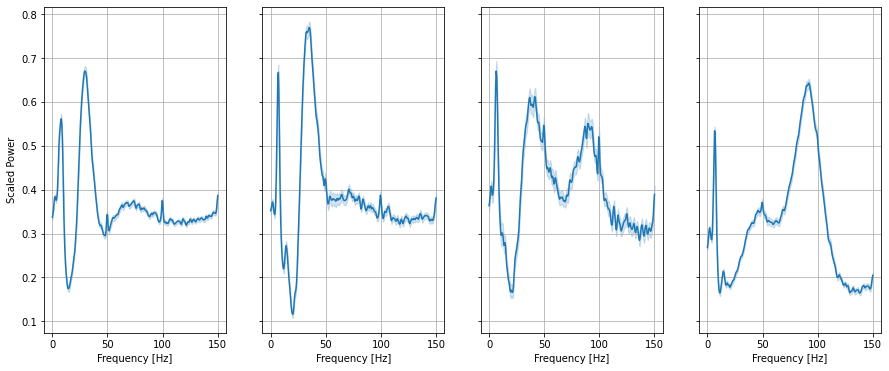

In [12]:
fig, ax = plt.subplots(1,4,figsize = (15,6), sharey = True);
dummy = pd.DataFrame(X);
faxis = np.arange(0, 150.5, 0.5);
for ix in range(4):
  a = dummy.loc[y == ix,'0':'300'];
  a.columns = faxis;
  a = a.reset_index();

  melted = a.melt(id_vars='index', var_name='faxis', value_name='power_spectra').sort_index('index')
  melted.rename(columns={'index':'bindex'}, inplace=True);
  melted.faxis = melted.faxis.astype('category');
  melted.sort_values('bindex', inplace = True)

  sns.lineplot(data = melted, x = 'faxis', y = 'power_spectra', ax = ax[ix])
  ax[ix].set_xlabel('Frequency [Hz]')
  ax[ix].set_ylabel('Scaled Power');
  ax[ix].grid();
plt.show();

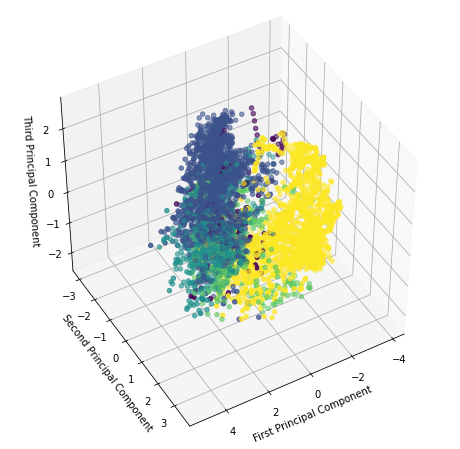

In [13]:
#Check how does the data looks like:

import numpy as np

# Initialize PCA
pca = PCA()

# Fit the PCA model to the data
pca.fit(X)

# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components needed to explain at least 80% of the variance
n_components = np.argmax(cumulative_explained_variance >= 0.8) + 1

# Update the PCA model with the number of components needed to explain at least 80% of the variance
pca = PCA(n_components=n_components)
pca.fit(X)

# Perform dimensionality reduction on the data
X_reduced = pca.transform(X)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(projection='3d');

ax.scatter(X_reduced[:,0], X_reduced[:,1], X_reduced[:,2], c = y);
ax.set_xlabel("First Principal Component")
ax.set_ylabel("Second Principal Component")
ax.set_zlabel("Third Principal Component")
ax.view_init(45, 60);

plt.show()


## Predictive Model: 1D-CNN

In [14]:
'''
In this cell, the data_augmentation function takes in a 1D array arr, 
and the parameters sigma and alpha for jittering and magnitude warping respectively. 
The function returns the augmented array. The jitter and magnitude_warp functions 
implement the data augmentation techniques.

'''

def jitter(arr, sigma):
    return arr + np.random.normal(scale=sigma, size=arr.shape)

def magnitude_warp(arr, alpha):
    return arr * (1 + alpha * np.random.normal(size=arr.shape))

def data_augmentation(arr, sigma, alpha):
    arr = jitter(arr, sigma)
    arr = magnitude_warp(arr, alpha)
    return arr


In [15]:
num_features = np.shape(X)[1];
bStates = np.unique(y);
num_classes = len(bStates);

# Define the model
input_layer = Input(shape=(num_features, 1), dtype = 'float32')  # shape of input data
conv_layer1 = Conv1D(filters=100, kernel_size= 3, activation='relu', padding = 'same')(input_layer)
conv_layer2 = Conv1D(filters=100, kernel_size= 3, activation='relu', padding = 'same')(conv_layer1)
pool_layer1 = MaxPooling1D(pool_size=3)(conv_layer2)
conv_layer3 = Conv1D(filters=100, kernel_size= 3, activation='relu', padding = 'same')(pool_layer1)
conv_layer4 = Conv1D(filters=100, kernel_size= 3, activation='relu', padding = 'same')(conv_layer3)
pool_layer2 = AveragePooling1D(pool_size=3)(conv_layer4)
dropout_layer1 = Dropout(0.5)(pool_layer2)
flatten_layer = Flatten()(dropout_layer1)
dense1 = Dense(64, activation='relu')(flatten_layer)
dense2 = Dense(32, activation='relu')(dense1)
dense3 = Dense(16, activation='relu')(dense2)
dropout_layer2 = Dropout(0.2)(dense3)
output_layer = Dense(units=num_classes, activation='softmax')(dropout_layer2)  # output layer with 10 units and softmax activation

# Compile the model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 301, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 301, 100)          400       
                                                                 
 conv1d_1 (Conv1D)           (None, 301, 100)          30100     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 100, 100)         0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 100, 100)          30100     
                                                                 
 conv1d_3 (Conv1D)           (None, 100, 100)          30100     
                                                             

In [16]:
# Train the model
model_path = path + 'models';
save_weights_at = os.path.join(model_path, 'dysk.{epoch:02d}-{val_loss:.4f}.hdf5')
save_best = ModelCheckpoint(save_weights_at, monitor='val_loss', verbose=0,
                            save_best_only=True, save_weights_only=False, mode='min',
                            period=1);

# use 5-fold cross validation
kfold = StratifiedKFold(n_splits=5, shuffle=True);
scores = [];
lossx = [];
lossxval = [];
accx = [];
accxval = [];
count = 0

for train_index, test_index in kfold.split(X, y):

  X_train, X_test = X[train_index], X[test_index];
  y_train, y_test = y[train_index], y[test_index];

  taxis_train = np.array(df.taxis)[train_index,None];
  drug_train = np.array(df.Drug)[train_index,None];
  session_train = np.array(df.Session)[train_index,None];
  taxis_test = np.array(df.taxis)[test_index,None];
  drug_test = np.array(df.Drug)[test_index,None];
  session_test = np.array(df.Session)[test_index,None];

  # Apply data augmentation to the training data
  X_train = np.array([data_augmentation(arr, sigma=0.1, alpha=0.1) for arr in X_train])

  # Reshape input data
  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

  # Convert the labels to categorical format
  y_train = keras.utils.to_categorical(y_train, num_classes=num_classes)
  y_test = keras.utils.to_categorical(y_test, num_classes=num_classes)

  history = model.fit(X_train, y_train, batch_size=32, epochs=20, verbose=1, shuffle=True, callbacks=[save_best], validation_data=(X_test, y_test));

  lossx.append(history.history['loss']);
  lossxval.append(history.history['val_loss']);
  accx.append(history.history['accuracy']);
  accxval.append(history.history['val_accuracy']);
  
  _, acc = model.evaluate(X_test, y_test, verbose=0)

  scores.append(acc)
  count = count + 1;

print("Accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(scores)*100, np.std(scores)*100))


Epoch 1/20
116/116 [==============================] - 18s 45ms/step - loss: 1.0205 - accuracy: 0.6346 - val_loss: 0.6507 - val_accuracy: 0.7767
Epoch 2/20
116/116 [==============================] - 1s 10ms/step - loss: 0.6660 - accuracy: 0.7673 - val_loss: 0.5605 - val_accuracy: 0.7864
Epoch 3/20
116/116 [==============================] - 1s 9ms/step - loss: 0.5841 - accuracy: 0.7934 - val_loss: 0.5297 - val_accuracy: 0.8101
Epoch 4/20
116/116 [==============================] - 1s 10ms/step - loss: 0.5412 - accuracy: 0.7934 - val_loss: 0.5054 - val_accuracy: 0.8296
Epoch 5/20
116/116 [==============================] - 1s 11ms/step - loss: 0.5167 - accuracy: 0.8061 - val_loss: 0.4702 - val_accuracy: 0.8252
Epoch 6/20
116/116 [==============================] - 1s 8ms/step - loss: 0.4715 - accuracy: 0.8128 - val_loss: 0.4607 - val_accuracy: 0.8209
Epoch 7/20
116/116 [==============================] - 1s 10ms/step - loss: 0.4563 - accuracy: 0.8217 - val_loss: 0.4416 - val_accuracy: 0.8371


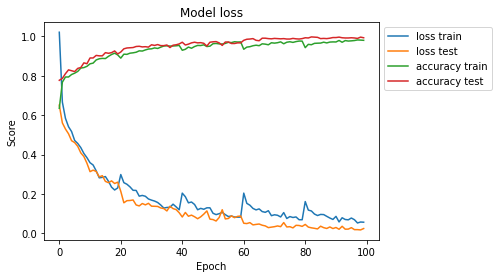

In [17]:
# Plot the training and validation loss
plt.plot(sum(lossx, []), label = 'loss train');
plt.plot(sum(lossxval, []), label = 'loss test');
plt.plot(sum(accx, []), label = 'accuracy train');
plt.plot(sum(accxval, []), label = 'accuracy test');
plt.title('Model loss')
plt.ylabel('Score')
plt.xlabel('Epoch')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1));
plt.show()

In [18]:
# Get the index of the epoch with the lowest validation loss
min_loss_index = np.argmin(history.history['val_loss']);

# Get the best validation loss and best epoch number
best_val_loss = history.history['val_loss'][min_loss_index];
best_epoch = min_loss_index + 1;

print("Best Validation Loss: {:.4f} at epoch {}".format(best_val_loss, best_epoch));

Best Validation Loss: 0.0177 at epoch 19


In [19]:
best_model = load_model(os.path.join(model_path, f'dysk.{best_epoch:02d}-{best_val_loss:.4f}.hdf5'));

# Get the predicted probabilities
pred_probs = best_model.predict(X_test);

# The shape of pred_probs will be (number of test samples, number of classes)
print(pred_probs.shape)

# Each row represents the predicted probabilities for a single test sample
print(pred_probs[0])

29/29 [==============================] - 0s 2ms/step
(927, 5)
[9.9999619e-01 1.0384805e-06 2.0032724e-06 2.3794177e-11 6.8624325e-07]


In [20]:
originalStates = np.argmax(y_test, axis = 1);
predStates = np.argmax(pred_probs, axis = 1)
print(f'Original States: {np.unique(originalStates)}');
print(f'Predicted States: {np.unique(predStates)}');

Original States: [0 1 2 3 4]
Predicted States: [0 1 2 3 4]


In [21]:
mae = mean_absolute_error(originalStates, predStates)
print(f'MAE for the validation set: {mae:.4f}')

MAE for the validation set: 0.0043


In [22]:
r2 = r2_score(predStates, originalStates)
print('R-squared for the validation set:', round(r2,4))

R-squared for the validation set: 0.9978


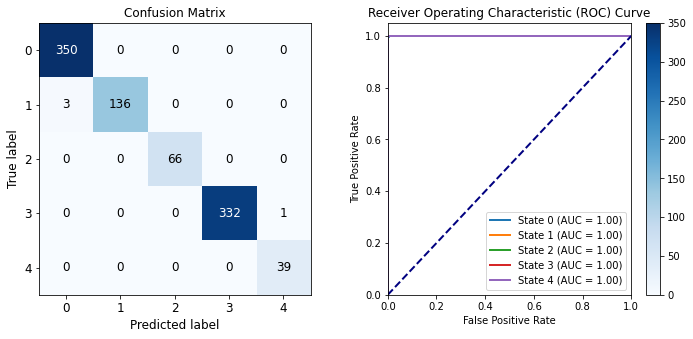

In [23]:
# Plot the confusion matrix and the ROC curve in the same figure
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot the confusion matrix
plot_confusion_matrix(originalStates, predStates, title = 'Confusion Matrix',text_fontsize = 'large', 
                      title_fontsize = 'large', ax = ax[0])
ax[0].set_xlabel("Predicted label")
ax[0].set_ylabel("True label")
ax[0].set_title("Confusion Matrix")

# Plot the ROC curve
bStates = np.unique(originalStates);
for k in range(len(bStates)):
  fpr, tpr, thresholds = roc_curve(originalStates == bStates[k], pred_probs[:,k]);
  roc_auc = auc(fpr, tpr)

  ax[1].plot(fpr, tpr, lw=2, label= f'State {bStates[k]} (AUC = {roc_auc:0.2f})')

ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Receiver Operating Characteristic (ROC) Curve')
ax[1].legend(loc="lower right")

plt.show()

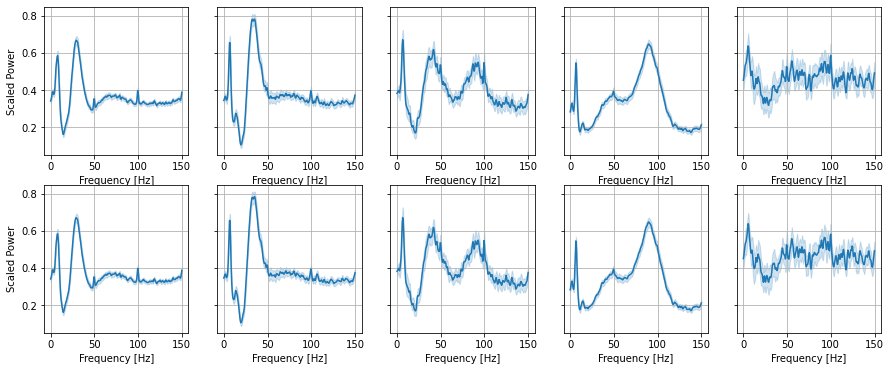

In [24]:
fig, ax = plt.subplots(2,len(bStates),figsize = (15,6), sharey = True);
X_testx = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))
dummy = pd.DataFrame(X_testx);
faxis = np.arange(0, 150.5, 0.5);

for ix in range(len(bStates)):
  a = dummy.loc[originalStates == ix,'0':'300'];
  a.columns = faxis;
  a = a.reset_index();

  melted = a.melt(id_vars='index', var_name='faxis', value_name='power_spectra').sort_index('index')
  melted.rename(columns={'index':'bindex'}, inplace=True);
  melted.faxis = melted.faxis.astype('category');
  melted.sort_values('bindex', inplace = True)

  sns.lineplot(data = melted, x = 'faxis', y = 'power_spectra', ax = ax[0,ix])
  ax[0,ix].set_xlabel('Frequency [Hz]')
  ax[0,ix].set_ylabel('Scaled Power');
  ax[0,ix].grid();

  a = dummy.loc[predStates == ix,'0':'300'];
  a.columns = faxis;
  a = a.reset_index();

  melted = a.melt(id_vars='index', var_name='faxis', value_name='power_spectra').sort_index('index')
  melted.rename(columns={'index':'bindex'}, inplace=True);
  melted.faxis = melted.faxis.astype('category');
  melted.sort_values('bindex', inplace = True)

  sns.lineplot(data = melted, x = 'faxis', y = 'power_spectra', ax = ax[1,ix])
  ax[1,ix].set_xlabel('Frequency [Hz]')
  ax[1,ix].set_ylabel('Scaled Power');
  ax[1,ix].grid();


plt.show();

### Apply the model to the rest of the data:

In [90]:
#Get a copy form the original:
dfx = Data.copy();
dfx.dropna(subset=['Session'], axis=0, inplace=True);
dfx.reset_index(drop=True, inplace=True);
Acc = dfx.Acc;
Hemi = dfx.Hemi;
AIMS = dfx.AIMS;
Drug = dfx.Drug.astype(int);
Session = dfx.Session;
taxis = dfx.taxis;
State = dfx.State;
State[State == 4] = None; #This state will not be counted
State[State == -1] = 4; #Noise state will be set as 4

In [39]:
#Scale the rest of the Data:
scaler = MinMaxScaler();
dummy = dfx.iloc[:, range(len(faxis))];
result = scaler.fit_transform(dummy.T)
Xx = result.T;

In [40]:
# Get the predicted probabilities
originalStates = State.astype('category');
pred_probs = best_model.predict(np.reshape(Xx, (Xx.shape[0], Xx.shape[1], 1)));
predStates = np.argmax(pred_probs, axis = 1);

14481/14481 [==============================] - 89s 6ms/step


In [98]:
bSessions = np.unique(Session);
idx = random.randint(0,len(bSessions));
idx

35

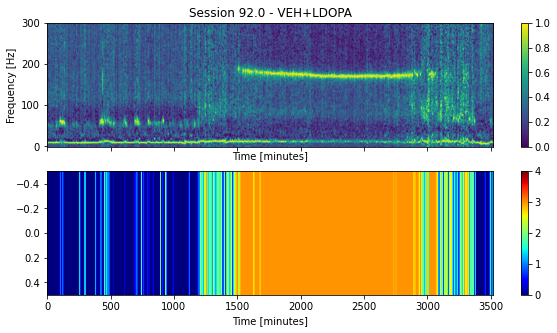

In [99]:
sel = np.logical_and(Session == bSessions[ix], Hemi == 2);
spg = Xx[sel,:].T;
btaxis = taxis[sel];
bOrStates = np.array(originalStates[sel]);
bPredStates = np.array(predStates[sel]);
bDrugs = ['VEH+LDOPA', 'VEH+SKF', 'VEH+SUM', 'VEH+VEH'];

fig, ax = plt.subplots(2,1, figsize = (10,5), sharex = True)
pcm = ax[0].imshow(spg, aspect = 'auto');
ax[0].invert_yaxis();
fig.colorbar(pcm, ax=ax[0])
#ax.set_xticks(range(0,spg.shape[1]));
#ax.set_yticks(range(0,spg.shape[0]));
#ax.set_xticklabels(btaxis);
#ax.set_yticklabels(faxis);
ax[0].set_xlabel('Time [minutes]');
ax[0].set_ylabel('Frequency [Hz]');
ax[0].set_title(f'Session {bSessions[ix]} - {bDrugs[np.unique(Drug[sel])[0]-1]}');

plotStates1 = bOrStates.reshape((1, bOrStates.shape[0]));
plotStates2 = bPredStates.reshape((1, bPredStates.shape[0]));
pcm = ax[1].imshow(plotStates2, aspect = 'auto', cmap = 'jet');
cbar = fig.colorbar(pcm, ax=ax[1], spacing='proportional', format='%1i')
ax[1].set_xlabel('Time [minutes]');
plt.show();